# Data Cleaning

## 1. Operazioni preliminari

> Installazione dipendenze necessarie

In [ ]:
!pip install langdetect

In [ ]:
!pip install deep-translator

> Importazione delle librerie

In [4]:
import pandas as pd
from langdetect import detect
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import re
from tqdm.notebook import tqdm
from deep_translator import GoogleTranslator
from sklearn.preprocessing import RobustScaler

> Montaggio di Drive

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


> Lettura del dataset

In [8]:
# drive path
csv_path = '/content/drive/MyDrive/Progetto_FDSML_github/Fake-TikTok-Account-Detection/datasets/tiktok_accounts.csv'

In [ ]:
# local path
csv_path = '../datasets/tiktok_accounts.csv'

In [9]:
df = pd.read_csv(csv_path)
df.head()

,diggCount,followerCount,followingCount,heartCount,videoCount,commentSetting,downloadSetting,duetSetting,nickname,openFavorite,signature,stitchSetting,uniqueId,verified,fake
0,279,0,564,0,0,0,0,0,Tik Toker,False,No bio yet,0,gyzituvigy542,False,True
1,1198,71,9980,0,0,0,0,0,BEULAH,True,NaN,0,tshphjtowl2401583tbww,False,True
2,2968,596,1123,2062,266,0,0,0,Lello27,False,NaN,0,aristanismamojadanuoro,False,False
3,2351,200,818,435,36,0,0,0,clemevitale,False,NaN,0,clemevitale,False,False
4,40300,1100000,52,10000000,720,0,3,1,Saher Monther,False,YouTuber star ⭐️,0,sahermonther,True,False


## 2. Pulizia dei dati

> Creo una copia del dataset originale, in modo da non modificarlo direttamente

In [10]:
df_copy = df

### 2.1 Pulizia *signature*

> Sostituisce le signature con valore NaN e 'No bio yet' con la stringa vuota.

In [11]:
df_copy['signature'] = df_copy['signature'].fillna('')
df_copy['signature'] = df_copy['signature'].replace('No bio yet', '')

In [12]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10043 entries, 0 to 10042
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   diggCount        10043 non-null  int64 
 1   followerCount    10043 non-null  int64 
 2   followingCount   10043 non-null  int64 
 3   heartCount       10043 non-null  int64 
 4   videoCount       10043 non-null  int64 
 5   commentSetting   10043 non-null  int64 
 6   downloadSetting  10043 non-null  int64 
 7   duetSetting      10043 non-null  int64 
 8   nickname         10043 non-null  object
 9   openFavorite     10043 non-null  bool  
 10  signature        10043 non-null  object
 11  stitchSetting    10043 non-null  int64 
 12  uniqueId         10043 non-null  object
 13  verified         10043 non-null  bool  
 14  fake             10043 non-null  bool  
dtypes: bool(3), int64(9), object(3)
memory usage: 971.1+ KB


Aggiungo la feature per calcolare la lunghezza di ciascuna signature.

In [13]:
#Aggiungo la nuova feature
df_copy['signatureLength'] = 0

In [14]:
for i, signature in enumerate(df_copy['signature']):
    df_copy.loc[i, 'signatureLength'] = len(signature)

In [15]:
df_copy['signatureLength'].describe()

count    10043.000000
mean         9.077666
std         20.288095
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        131.000000
Name: signatureLength, dtype: float64

Verifico quanti sono i profili fake e real che hanno *signature* vuota.

In [ ]:
df_fake_accounts = df_copy[df_copy['fake'] == 1]
df_real_accounts = df_copy[df_copy['fake'] == 0]

print('Fake accounts:', len(df_fake_accounts))
print('Real accounts:', len(df_real_accounts))

Fake accounts: 5029
Real accounts: 5014


In [ ]:
df_fake_accounts_empty_signature = df_fake_accounts[df_fake_accounts['signatureLength'] == 0]
df_real_accounts_empty_signature = df_real_accounts[df_real_accounts['signatureLength'] == 0]

print('Fake accounts with null signature:', len(df_fake_accounts_empty_signature))
print('Real accounts with null signature:', len(df_real_accounts_empty_signature))

Fake accounts with null signature: 5021
Real accounts with null signature: 2671


Si nota subito che i profili real tendono ad avere *signatures* non nulle rispetto ai profili fake.

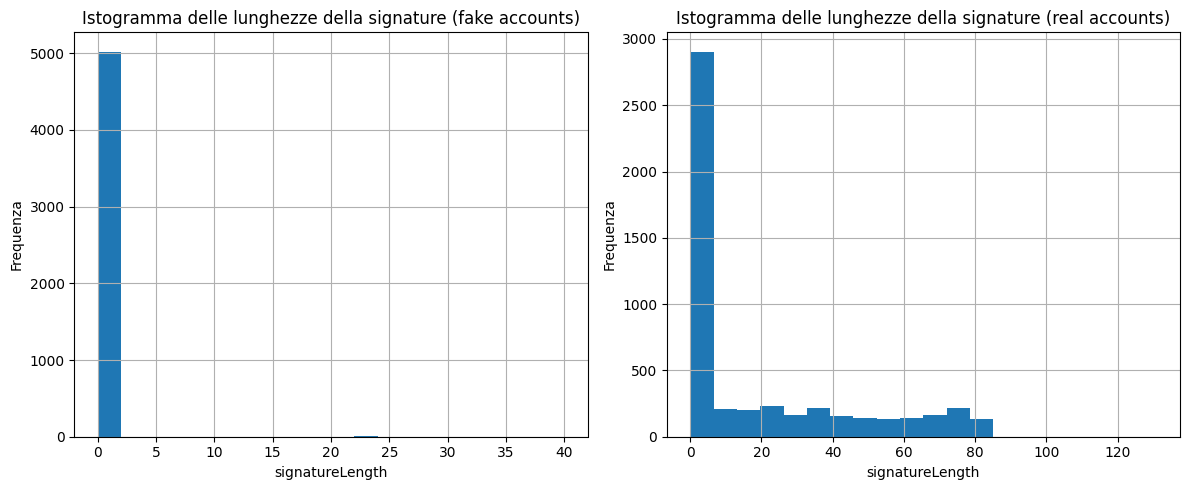

In [ ]:
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
df_fake_accounts['signatureLength'].hist(bins=20)
plt.xlabel('signatureLength')
plt.ylabel('Frequenza')
plt.title('Istogramma delle lunghezze della signature (fake accounts)')

plt.subplot(1, 2, 2)
df_real_accounts['signatureLength'].hist(bins=20)
plt.xlabel('signatureLength')
plt.ylabel('Frequenza')
plt.title('Istogramma delle lunghezze della signature (real accounts)')

plt.tight_layout()
plt.show()

Le istanze fake sono quelle che hanno lunghezza 0, mentre le real possono avere anche altre lunghezza e sono maggiormente distribuite su altri valori.

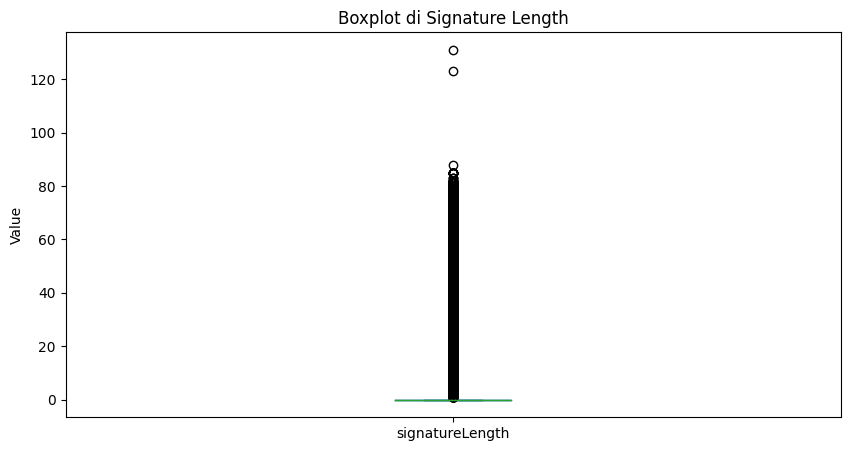

In [ ]:
# Visualizziamo un boxplot per controllare gli outliers
df_copy['signatureLength'].plot.box(figsize=(10,5))
plt.ylabel('Value')
plt.title('Boxplot di Signature Length')
plt.show()

> Ovviamente, risultano quasi tutti outliers perché la maggior parte della distribuzione è costituita da zeri.

In [ ]:
# Controlliamo se la nuova feature è stata aggiunta correttamente
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10043 entries, 0 to 10042
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   diggCount        10043 non-null  int64 
 1   followerCount    10043 non-null  int64 
 2   followingCount   10043 non-null  int64 
 3   heartCount       10043 non-null  int64 
 4   videoCount       10043 non-null  int64 
 5   commentSetting   10043 non-null  int64 
 6   downloadSetting  10043 non-null  int64 
 7   duetSetting      10043 non-null  int64 
 8   nickname         10043 non-null  object
 9   openFavorite     10043 non-null  bool  
 10  signature        10043 non-null  object
 11  stitchSetting    10043 non-null  int64 
 12  uniqueId         10043 non-null  object
 13  verified         10043 non-null  bool  
 14  fake             10043 non-null  bool  
 15  fakeNum          10043 non-null  int64 
 16  signatureLength  10043 non-null  int64 
dtypes: bool(3), int64(11), object(3

In [ ]:
df_copy.head()

,diggCount,followerCount,followingCount,heartCount,videoCount,commentSetting,downloadSetting,duetSetting,nickname,openFavorite,signature,stitchSetting,uniqueId,verified,fake,fakeNum,signatureLength
0,279,0,564,0,0,0,0,0,Tik Toker,False,,0,gyzituvigy542,False,True,1,0
1,1198,71,9980,0,0,0,0,0,BEULAH,True,,0,tshphjtowl2401583tbww,False,True,1,0
2,2968,596,1123,2062,266,0,0,0,Lello27,False,,0,aristanismamojadanuoro,False,False,0,0
3,2351,200,818,435,36,0,0,0,clemevitale,False,,0,clemevitale,False,False,0,0
4,40300,1100000,52,10000000,720,0,3,1,Saher Monther,False,YouTuber star ⭐️,0,sahermonther,True,False,0,16


### 2.2 Pulizia *nickname*

Creiamo due nuove features, una per la lunghezza del nickname e una per contare i caratteri speciali al suo interno. I caratteri speciali riguardano:
* numeri
* caratteri speciali (eg. , ; _ ' /)
* emoji

In [ ]:
df_copy['nicknameLength'] = 0
df_copy['nicknameNumSpecialCharacters'] = 0

In [ ]:
# Ci assicuriamo che la creazione delle nuove features sia avvenuta correttamente
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10043 entries, 0 to 10042
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   diggCount                     10043 non-null  int64 
 1   followerCount                 10043 non-null  int64 
 2   followingCount                10043 non-null  int64 
 3   heartCount                    10043 non-null  int64 
 4   videoCount                    10043 non-null  int64 
 5   commentSetting                10043 non-null  int64 
 6   downloadSetting               10043 non-null  int64 
 7   duetSetting                   10043 non-null  int64 
 8   nickname                      10043 non-null  object
 9   openFavorite                  10043 non-null  bool  
 10  signature                     10043 non-null  object
 11  stitchSetting                 10043 non-null  int64 
 12  uniqueId                      10043 non-null  object
 13  verified        

Per l'attributo *nicknameNumSpecialCharacters* l'idea è creare 4 classi:
* 0 - nickname con 0 caratteri
* 1 - nickname con 1 solo carattere
* 2 - nickname con 2 caratteri
* 3 - nickname con 3 caratteri o più


> Prima verifichiamo le lingue diverse dall'inglese presenti nell'attributo *nickname*.

In [ ]:
language_set = set()

for nickname in tqdm(df_copy['nickname'], desc='Verifico lingua in nickname', total=len(df_copy)):
  try:
      language = detect(nickname)
      if language != 'en':
        language_set.add(language)
  except:
    continue

print(f'Lingue rilevate: {language_set}')
print(f'Numero di lingue rilevate: {len(language_set)}')

Verifico lingua in nickname:   0%|          | 0/10043 [00:00<?, ?it/s]

Lingue rilevate: {'hu', 'et', 'th', 'ur', 'ro', 'cy', 'fa', 'sk', 'no', 'so', 'fr', 'ja', 'ca', 'lt', 'it', 'sw', 'lv', 'mk', 'zh-cn', 'tl', 'el', 'bg', 'id', 'hr', 'ko', 'da', 'pt', 'bn', 'de', 'he', 'pl', 'sv', 'es', 'af', 'fi', 'nl', 'ru', 'cs', 'sl', 'ar', 'sq', 'vi', 'tr', 'uk'}
Numero di lingue rilevate: 44


> Ci sono 44 lingue diverse dall'inglese ed, essendo che per contare i caratteri danno problemi le lingue non latine, si prova a tradurle.

In [ ]:
# dopo una verifica manuale, sono state aggiunte anche zh-tw e bn, le quali non sono state rilevate da langdetect
languages_not_latin = ["el", "ur", "ja", "mk", "ar", "fa", "bg", "th", "uk", "ru", "he", "zh-cn", "ko", "zh-tw", "bn"]

error_indexes = []

df_copy['nicknameTranslate'] = df_copy['nickname']

for i, nickname in tqdm(enumerate(df_copy['nickname']), desc='Traduco nickname', total=len(df_copy)):
  try:
      language = detect(nickname)
      if language in languages_not_latin:
        try:
          translation = GoogleTranslator(target='en', source=language)
          df_copy.loc[i, 'nicknameTranslate'] = translation.translate(nickname)
        except Exception as e:
          print(f"{i}-esima istanza ha avuto un problema durante la traduzione")
          error_indexes.append(i)
          continue
  except:
    continue

Traduco nickname:   0%|          | 0/10043 [00:00<?, ?it/s]

460-esima istanza ha avuto un problema durante la traduzione
509-esima istanza ha avuto un problema durante la traduzione
529-esima istanza ha avuto un problema durante la traduzione
805-esima istanza ha avuto un problema durante la traduzione
1071-esima istanza ha avuto un problema durante la traduzione
1348-esima istanza ha avuto un problema durante la traduzione
2485-esima istanza ha avuto un problema durante la traduzione
3268-esima istanza ha avuto un problema durante la traduzione
4122-esima istanza ha avuto un problema durante la traduzione
4480-esima istanza ha avuto un problema durante la traduzione
4549-esima istanza ha avuto un problema durante la traduzione
4704-esima istanza ha avuto un problema durante la traduzione
5077-esima istanza ha avuto un problema durante la traduzione
5199-esima istanza ha avuto un problema durante la traduzione
5615-esima istanza ha avuto un problema durante la traduzione
5630-esima istanza ha avuto un problema durante la traduzione
5721-esima i

> Le istanze su cui sono state sollevate eccezioni durante la traduzione e alcune istanze che non hanno sollevato eccezione, ma che presentavano caratteri non latini, sono state tradotte manualmente in lingua inglese dopo una verifica manuale.

In [ ]:
df_copy.loc[460, 'nicknameTranslate'] = 'When you grow up, you will understand, and when you understand, you will grow up 🫦'
df_copy.loc[509, 'nicknameTranslate'] = 'Giora Chamizer'
df_copy.loc[529, 'nicknameTranslate'] = 'maybe'
df_copy.loc[805, 'nicknameTranslate'] = 'Fulham Israel'
df_copy.loc[1071, 'nicknameTranslate'] = "It's like in this chapter in the 'eighth' ♾️"
df_copy.loc[1348, 'nicknameTranslate'] = 'Muadh'
df_copy.loc[2485, 'nicknameTranslate'] = 'Network 13'
df_copy.loc[3268, 'nicknameTranslate'] = 'When fitness and values meet'
df_copy.loc[3695, 'nicknameTranslate'] = 'Shufang💋'
df_copy.loc[3937, 'nicknameTranslate'] = 'Israel Police - Israel Police'
df_copy.loc[4008, 'nicknameTranslate'] = 'If so'
df_copy.loc[4022, 'nicknameTranslate'] = 'Ahmed El Bayed / Ahmed Al Bayed'
df_copy.loc[4122, 'nicknameTranslate'] = 'The original with the mullet'
df_copy.loc[4480, 'nicknameTranslate'] = 'Michael Zorin'
df_copy.loc[4549, 'nicknameTranslate'] = '⚽️ The official retirement ⚽️'
df_copy.loc[4565, 'nicknameTranslate'] = 'G | G'
df_copy.loc[4704, 'nicknameTranslate'] = 'Ortzuk ;)'
df_copy.loc[5048, 'nicknameTranslate'] = 'JFootballJFootballTV'
df_copy.loc[5077, 'nicknameTranslate'] = 'Alina Rabinovich'
df_copy.loc[5199, 'nicknameTranslate'] = 'Then break the bucket and illuminate the place(◔‿◔)'
df_copy.loc[5615, 'nicknameTranslate'] = 'Oren Yadgar - oren yadgar'
df_copy.loc[5630, 'nicknameTranslate'] = 'Eyal'
df_copy.loc[5654, 'nicknameTranslate'] = 'Yas Island Yas Island'
df_copy.loc[5721, 'nicknameTranslate'] = 'Israel entertainment'
df_copy.loc[6179, 'nicknameTranslate'] = 'Padbol 🇸🇦'
df_copy.loc[6279, 'nicknameTranslate'] = 'The best audience in the country'
df_copy.loc[6506, 'nicknameTranslate'] = 'Police gaming - PUBG Police'
df_copy.loc[6695, 'nicknameTranslate'] = 'Guy Hochman'
df_copy.loc[7114, 'nicknameTranslate'] = 'Ahmed Hushan'
df_copy.loc[7616, 'nicknameTranslate'] = 'Bilal Haddad | Bilal Al-Haddad'
df_copy.loc[7645, 'nicknameTranslate'] = 'Roll era'
df_copy.loc[7780, 'nicknameTranslate'] = 'Lior Leibushor'
df_copy.loc[7803, 'nicknameTranslate'] = "Do Thi' Duy Y'"
df_copy.loc[8111, 'nicknameTranslate'] = 'hmx | hemex ⚽️'
df_copy.loc[8378, 'nicknameTranslate'] = 'Harel collected'
df_copy.loc[8680, 'nicknameTranslate'] = 'The hot news'
df_copy.loc[8741, 'nicknameTranslate'] = 'Emy Yemini | My mother is right-handed'
df_copy.loc[9032, 'nicknameTranslate'] = 'MELAMED | teaches'
df_copy.loc[9526, 'nicknameTranslate'] = 'ALBI Mamouya ALBI'
df_copy.loc[9839, 'nicknameTranslate'] = 'Jubilee 🤗'

In [ ]:
df_copy['nicknameTranslate']

0                Tik Toker
1                   BEULAH
2                  Lello27
3              clemevitale
4            Saher Monther
               ...        
10038          Futtedits23
10039            marcobobo
10040               Thomas
10041            Tik Toker
10042    Michela Cristiano
Name: nicknameTranslate, Length: 10043, dtype: object

> Le istanze su cui il tool ha avuto difficoltà di traduzione sono in lingua ebraica, cinese e arabo.

> Quindi, si contano i caratteri speciali senza contare accenti tipici di una lingua, e si assegna la lunghezza all'attributo relativo.

In [ ]:
pattern = re.compile(
        r'[^a-zA-Z '
        r'àèìòùÀÈÌÒÙ'  # accento grave
        r'áéíóúÁÉÍÓÚ'  # accento acuto
        r'äëïöüÄËÏÖÜ'  # dieresi (umlaut)
        r'âêîôûÂÊÎÔÛ'  # accento circonflesso
        r'ãõñÃÕÑ'      # tilde
        r'çÇ'          # cediglia
        r'ăĕĭŏŭĂĔĬŎŬ'  # accento breve
        r'āēīōūĀĒĪŌŪ'  # accento macron
        r'čďěǧǩľňřšťžČĎĚǦǨĽŇŘŠŤŽ'  # caron (hacek)
        r'ąęįǫųĄĘĮǪŲ'  # accento ogonek
        r'ėĖ'          # punto sopra
        r'ũṽŨṼ'        # tilde sopra
        r'łŁ'          # barra sopra
        r'őűŐŰ'        # accento doppio acuto
        r'ȧȦ'          # accento sopra
        r']'
    )

for i, nickname in tqdm(enumerate(df_copy['nickname']), desc='Calcolo feature derivate da nickname', total=len(df_copy)):
    df_copy.loc[i, 'nicknameLength'] = len(nickname)

    if nickname == '':
        print(f'{i}-esima istanza ha nickname vuoto')
        df_copy.loc[i, 'nicknameNumSpecialCharacters'] = 0
        continue

    # Si usa il nickname tradotto per rilevare caratteri speciali
    nickname_translate = df_copy.loc[i, 'nicknameTranslate']
    special_characters = pattern.findall(nickname_translate)

    if len(special_characters) == 0: df_copy.loc[i, 'nicknameNumSpecialCharacters'] = 0
    if len(special_characters) == 1: df_copy.loc[i, 'nicknameNumSpecialCharacters'] = 1
    if len(special_characters) == 2: df_copy.loc[i, 'nicknameNumSpecialCharacters'] = 2
    if len(special_characters) >= 3: df_copy.loc[i, 'nicknameNumSpecialCharacters'] = 3

Calcolo feature derivate da nickname:   0%|          | 0/10043 [00:00<?, ?it/s]

In [ ]:
df_fake_accounts = df_copy[df_copy['fake'] == 1]
df_real_accounts = df_copy[df_copy['fake'] == 0]

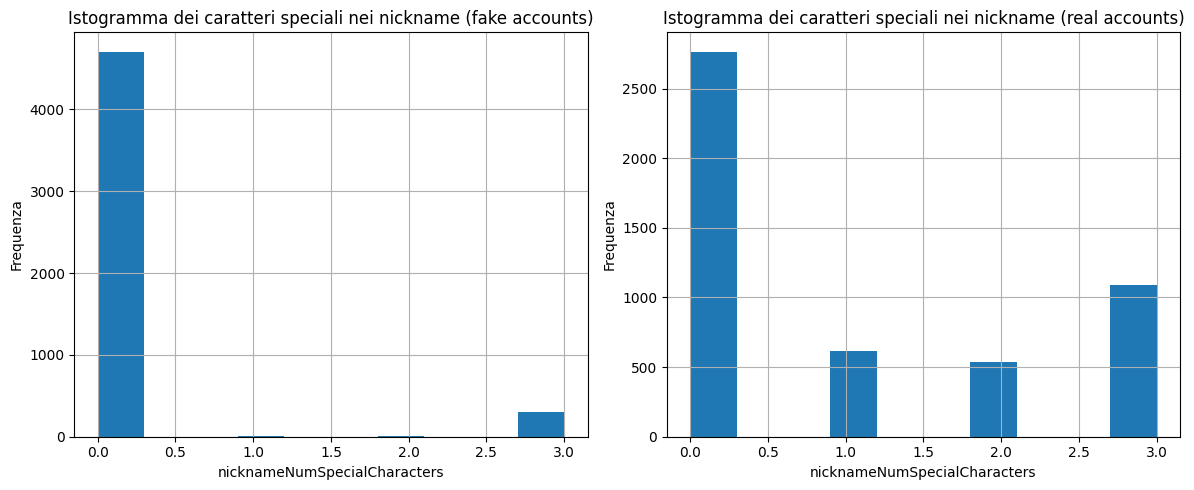

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
df_fake_accounts['nicknameNumSpecialCharacters'].hist()
plt.xlabel('nicknameNumSpecialCharacters')
plt.ylabel('Frequenza')
plt.title('Istogramma dei caratteri speciali nei nickname (fake accounts)')

plt.subplot(1, 2, 2)
df_real_accounts['nicknameNumSpecialCharacters'].hist()
plt.xlabel('nicknameNumSpecialCharacters')
plt.ylabel('Frequenza')
plt.title('Istogramma dei caratteri speciali nei nickname (real accounts)')

plt.tight_layout()
plt.show()

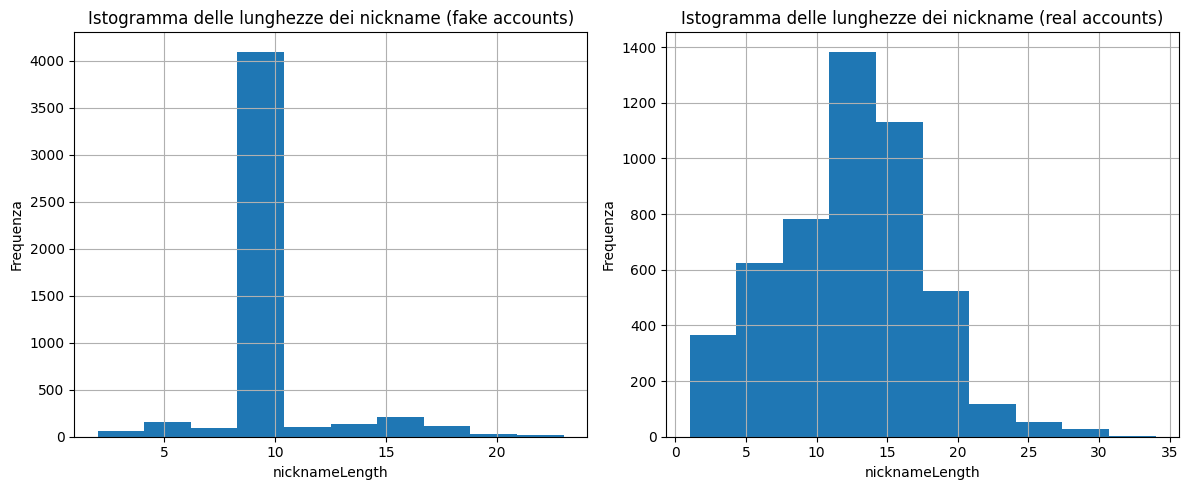

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
df_fake_accounts['nicknameLength'].hist()
plt.xlabel('nicknameLength')
plt.ylabel('Frequenza')
plt.title('Istogramma delle lunghezze dei nickname (fake accounts)')

plt.subplot(1, 2, 2)
df_real_accounts['nicknameLength'].hist()
plt.xlabel('nicknameLength')
plt.ylabel('Frequenza')
plt.title('Istogramma delle lunghezze dei nickname (real accounts)')

plt.tight_layout()
plt.show()

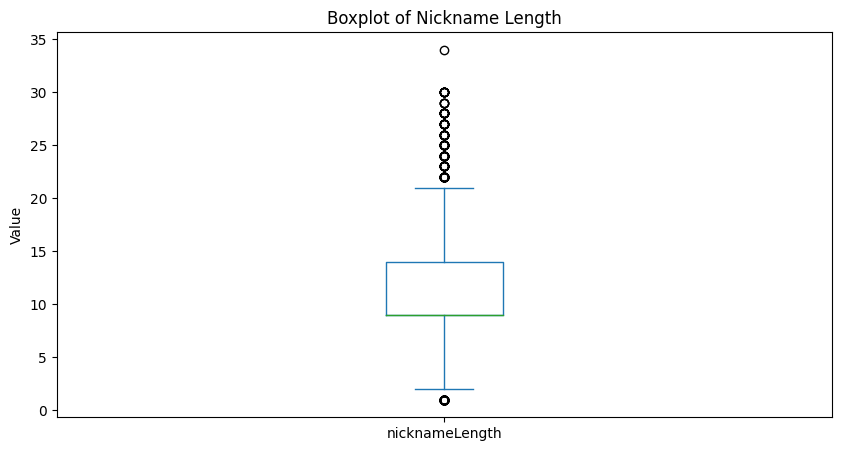

In [ ]:
df_copy['nicknameLength'].plot.box(figsize=(10,5))
plt.ylabel('Value')
plt.title('Boxplot of Nickname Length')
plt.show()

In [ ]:
df_copy.head()

,diggCount,followerCount,followingCount,heartCount,videoCount,commentSetting,downloadSetting,duetSetting,nickname,openFavorite,signature,stitchSetting,uniqueId,verified,fake,fakeNum,signatureLength,nicknameLength,nicknameNumSpecialCharacters,nicknameTranslate
0,279,0,564,0,0,0,0,0,Tik Toker,False,,0,gyzituvigy542,False,True,1,0,9,0,Tik Toker
1,1198,71,9980,0,0,0,0,0,BEULAH,True,,0,tshphjtowl2401583tbww,False,True,1,0,6,0,BEULAH
2,2968,596,1123,2062,266,0,0,0,Lello27,False,,0,aristanismamojadanuoro,False,False,0,0,7,2,Lello27
3,2351,200,818,435,36,0,0,0,clemevitale,False,,0,clemevitale,False,False,0,0,11,0,clemevitale
4,40300,1100000,52,10000000,720,0,3,1,Saher Monther,False,YouTuber star ⭐️,0,sahermonther,True,False,0,16,13,0,Saher Monther


In [ ]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10043 entries, 0 to 10042
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   diggCount                     10043 non-null  int64 
 1   followerCount                 10043 non-null  int64 
 2   followingCount                10043 non-null  int64 
 3   heartCount                    10043 non-null  int64 
 4   videoCount                    10043 non-null  int64 
 5   commentSetting                10043 non-null  int64 
 6   downloadSetting               10043 non-null  int64 
 7   duetSetting                   10043 non-null  int64 
 8   nickname                      10043 non-null  object
 9   openFavorite                  10043 non-null  bool  
 10  signature                     10043 non-null  object
 11  stitchSetting                 10043 non-null  int64 
 12  uniqueId                      10043 non-null  object
 13  verified        

### 2.3 Pulizia *uniqueId*

Creiamo due nuove features, una per la lunghezza di *uniqueId* e una per contare i numeri al suo interno (in quanto i fake accounts tendono ad avere molti numeri su questa feature).

In [ ]:
df_copy['uniqueIdNumDigits'] = 0
df_copy['uniqueIdLength'] = 0

In [ ]:
pattern = re.compile(r'\d')

for i, uniqueId in tqdm(enumerate(df['uniqueId']), desc="Calcolo feature derivate da uniqueId", total=len(df_copy)):
    df_copy.loc[i, 'uniqueIdLength'] = len(uniqueId)
    list_pattern = pattern.findall(uniqueId)
    len_list_pattern = len(list_pattern)

    if len_list_pattern == 0: df_copy.loc[i, 'uniqueIdNumDigits'] = 0
    if len_list_pattern == 1: df_copy.loc[i, 'uniqueIdNumDigits'] = 1
    if len_list_pattern == 2: df_copy.loc[i, 'uniqueIdNumDigits'] = 2
    if len_list_pattern >= 3: df_copy.loc[i, 'uniqueIdNumDigits'] = 3

Calcolo feature derivate da uniqueId:   0%|          | 0/10043 [00:00<?, ?it/s]

In [ ]:
df_fake_accounts = df_copy[df_copy['fake'] == 1]
df_real_accounts = df_copy[df_copy['fake'] == 0]

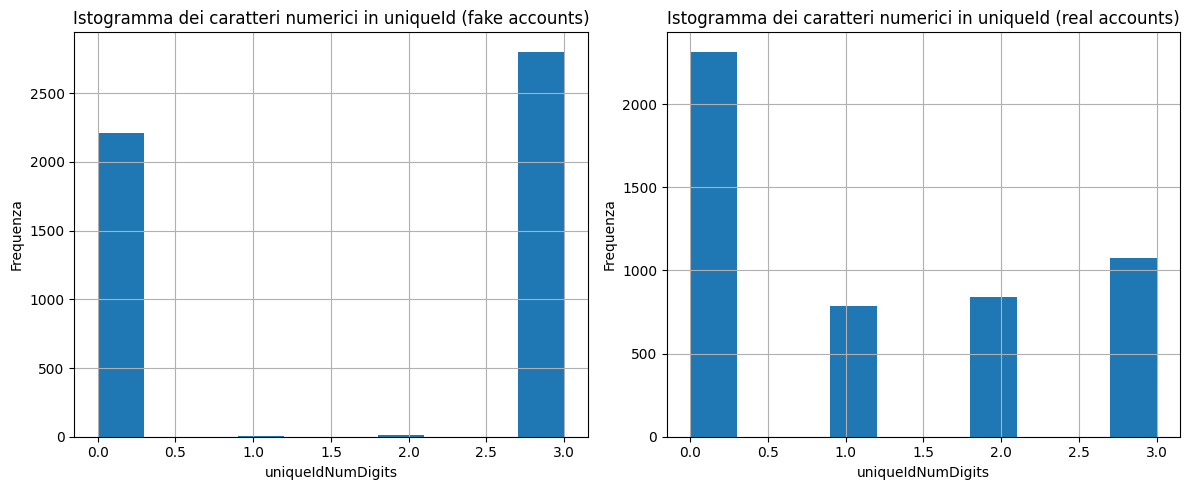

In [ ]:
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
df_fake_accounts['uniqueIdNumDigits'].hist()
plt.xlabel('uniqueIdNumDigits')
plt.ylabel('Frequenza')
plt.title('Istogramma dei caratteri numerici in uniqueId (fake accounts)')

plt.subplot(1, 2, 2)
df_real_accounts['uniqueIdNumDigits'].hist()
plt.xlabel('uniqueIdNumDigits')
plt.ylabel('Frequenza')
plt.title('Istogramma dei caratteri numerici in uniqueId (real accounts)')

plt.tight_layout()
plt.show()

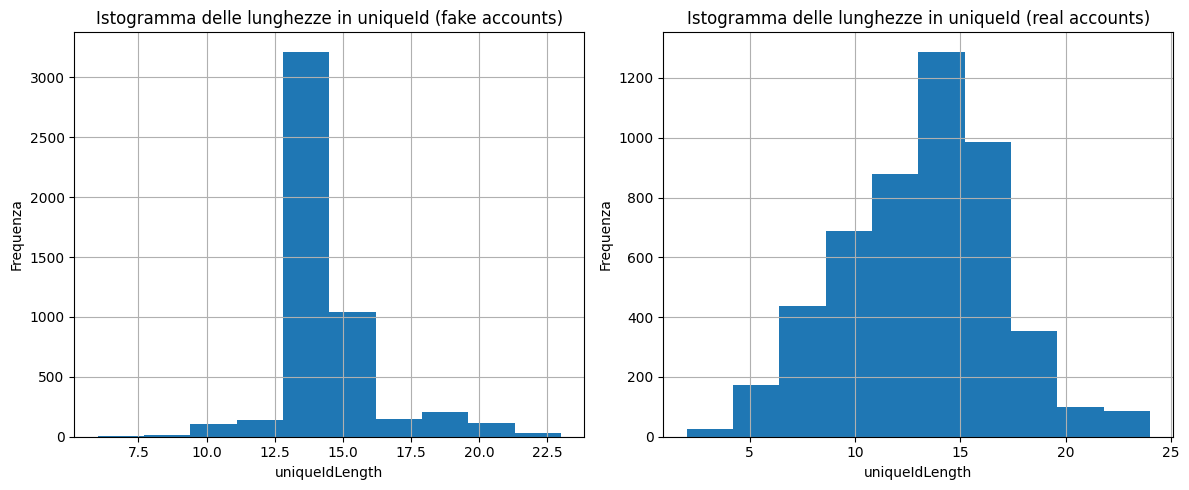

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
df_fake_accounts['uniqueIdLength'].hist()
plt.xlabel('uniqueIdLength')
plt.ylabel('Frequenza')
plt.title('Istogramma delle lunghezze in uniqueId (fake accounts)')

plt.subplot(1, 2, 2)
df_real_accounts['uniqueIdLength'].hist()
plt.xlabel('uniqueIdLength')
plt.ylabel('Frequenza')
plt.title('Istogramma delle lunghezze in uniqueId (real accounts)')

plt.tight_layout()
plt.show()

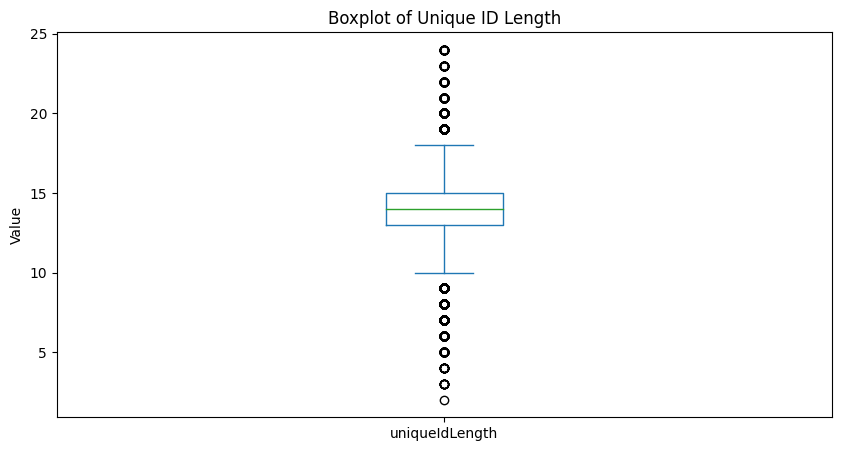

In [ ]:
# Visualizziamo l'istogramma per osservare gli outliers
df_copy['uniqueIdLength'].plot.box(figsize=(10,5))
plt.ylabel('Value')
plt.title('Boxplot of Unique ID Length')
plt.show()

### 2.4 Pulizia *diggCount*

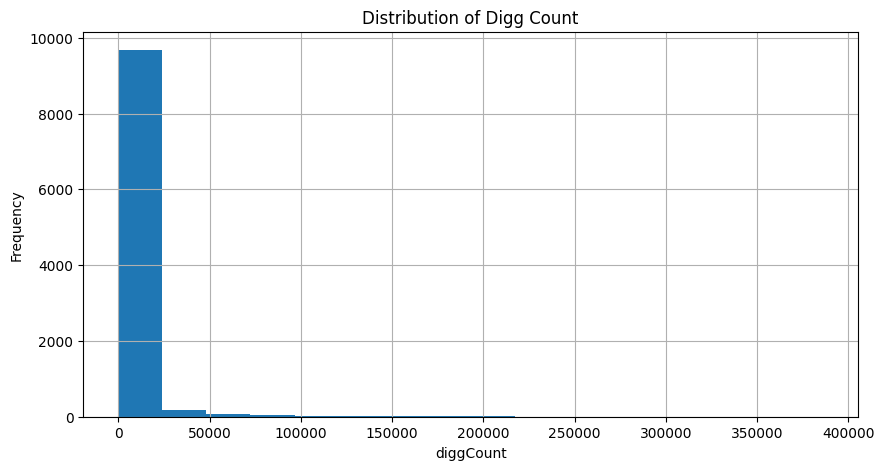

In [ ]:
# Visualizziamo l'istogramma del singolo attributo
df_copy['diggCount'].hist(bins=16, figsize=(10,5))
plt.xlabel('diggCount')
plt.ylabel('Frequency')
plt.title('Distribution of Digg Count')
plt.show()

In [ ]:
df_copy['diggCount'].describe()

count     10043.000000
mean       3893.421189
std       17247.832989
min           0.000000
25%         195.000000
50%         358.000000
75%         761.000000
max      386100.000000
Name: diggCount, dtype: float64

#### Standardizzazione con StandardScaler

In [ ]:
scaler = StandardScaler()
data = df_copy[['diggCount', 'followerCount', 'followingCount', 'heartCount', 'videoCount', 'signatureLength', 'uniqueIdLength', 'nicknameLength']]
data_scaled = scaler.fit_transform(data)
df_standardized = pd.DataFrame(data_scaled, columns=data.columns)
df_standardized.head()

,diggCount,followerCount,followingCount,heartCount,videoCount,signatureLength,uniqueIdLength,nicknameLength
0,-0.209568,-0.101901,-0.219109,-0.104364,-0.212439,-0.447152,-0.223909,-0.459120
1,-0.156284,-0.101868,4.087096,-0.104364,-0.212439,-0.447152,2.369394,-1.154830
2,-0.053657,-0.101627,0.036538,-0.104310,0.641014,-0.447152,2.693556,-0.922927
3,-0.089431,-0.101809,-0.102948,-0.104353,-0.096934,-0.447152,-0.872235,0.004687
4,2.110897,0.403278,-0.453261,0.157961,2.097660,0.329291,-0.548072,0.468495


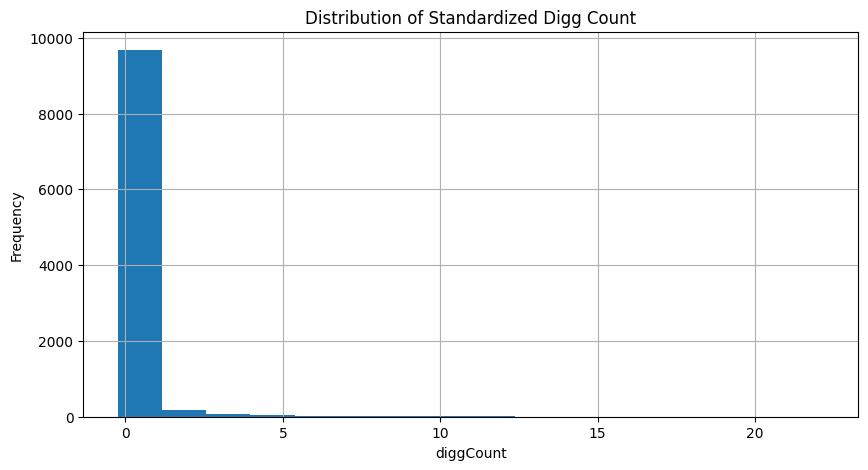

In [ ]:
# Visualizziamo l'istogramma dell'attributo dopo la scalatura
df_standardized['diggCount'].hist(bins=16, figsize=(10,5))
plt.xlabel('diggCount')
plt.ylabel('Frequency')
plt.title('Distribution of Standardized Digg Count')
plt.show()

In [ ]:
# Verifichiamo come sono cambiati i parametri rispetto a prima
df_standardized['diggCount'].describe()

count    1.004300e+04
mean    -9.197506e-18
std      1.000050e+00
min     -2.257452e-01
25%     -2.144388e-01
50%     -2.049879e-01
75%     -1.816215e-01
max      2.216079e+01
Name: diggCount, dtype: float64

Si è scelto di utilizzare lo StandardScaler.

In [ ]:
# Memorizzo i valori standardizzati in 'diggCount'
df_copy['diggCount'] = df_standardized['diggCount']

#### Quantile Transformation

In [ ]:
qt = QuantileTransformer(output_distribution='uniform')
df_copy['diggCount_quantile'] = qt.fit_transform(df_copy[['diggCount']])

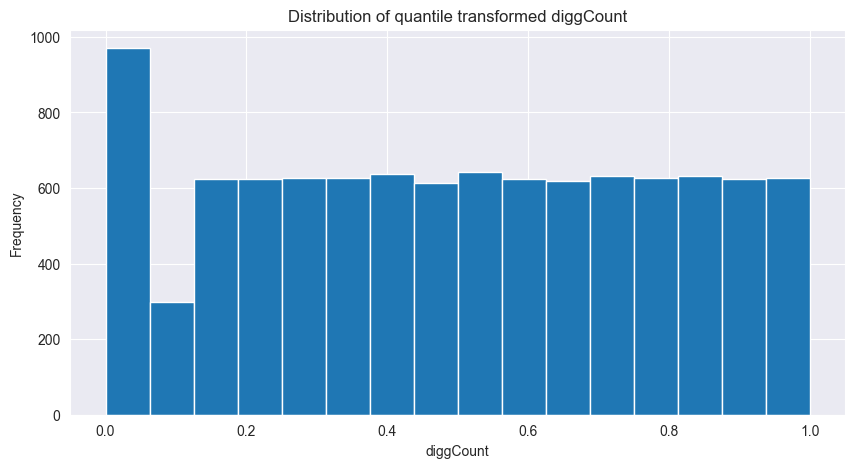

In [ ]:
df_copy['diggCount_quantile'].hist(bins=16, figsize=(10,5))
plt.xlabel('diggCount')
plt.ylabel('Frequency')
plt.title('Distribution of quantile transformed diggCount')
plt.show()

In [ ]:
df_copy['diggCount_quantile'].describe()

count    10043.000000
mean         0.495150
std          0.296097
min          0.000000
25%          0.249583
50%          0.500000
75%          0.749440
max          1.000000
Name: diggCount_quantile, dtype: float64

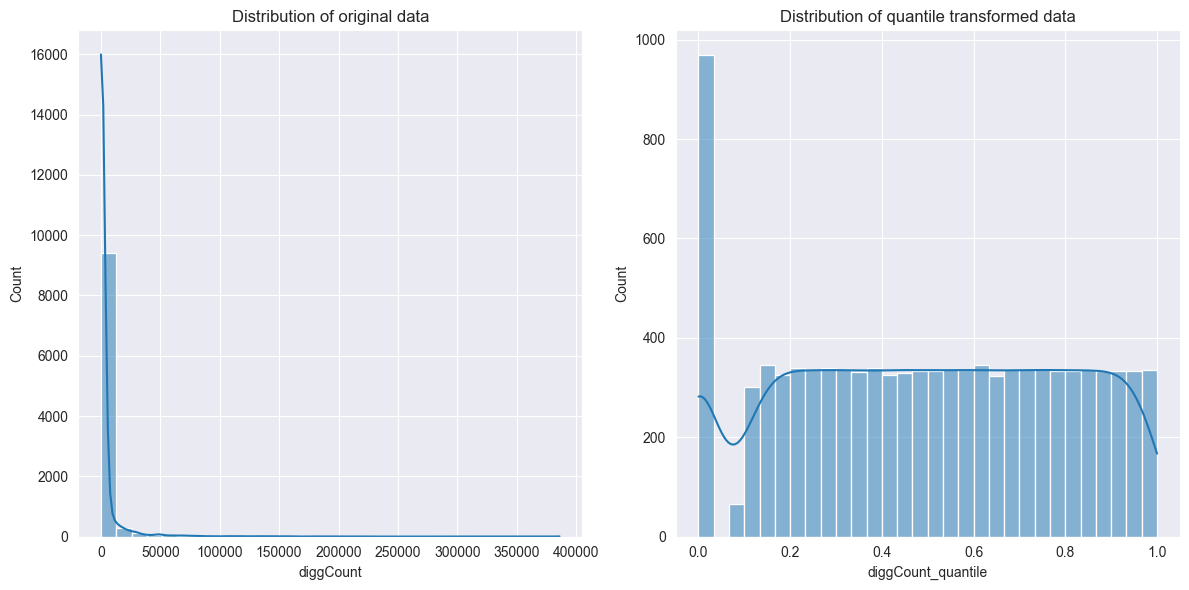

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(df['diggCount'], bins=30, kde=True)
plt.title('Distribution of original data')

plt.subplot(1, 2, 2)
sns.histplot(df_copy['diggCount_quantile'], bins=30, kde=True)
plt.title('Distribution of quantile transformed data')

plt.tight_layout()
plt.show()

In [ ]:
df_copy.head()

,diggCount,followerCount,followingCount,heartCount,videoCount,commentSetting,downloadSetting,duetSetting,nickname,openFavorite,...,verified,fake,fakeNum,signatureLength,nicknameLength,nicknameNumSpecialCharacters,nicknameTranslate,uniqueIdNumDigits,uniqueIdLength,diggCount_quantile
0,279,0,564,0,0,0,0,0,Tik Toker,False,...,False,True,1,0,9,0,Tik Toker,3,13,0.313814
1,1198,71,9980,0,0,0,0,0,BEULAH,True,...,False,True,1,0,6,0,BEULAH,3,21,0.786154
2,2968,596,1123,2062,266,0,0,0,Lello27,False,...,False,False,0,0,7,2,Lello27,0,22,0.854694
3,2351,200,818,435,36,0,0,0,clemevitale,False,...,False,False,0,0,11,0,clemevitale,0,11,0.838426
4,40300,1100000,52,10000000,720,0,3,1,Saher Monther,False,...,True,False,0,16,13,0,Saher Monther,0,12,0.977826


#### Min-Max Scaler

In [ ]:
scaler = MinMaxScaler()
df_copy['diggCount_minMax'] = scaler.fit_transform(df_copy[['diggCount']])

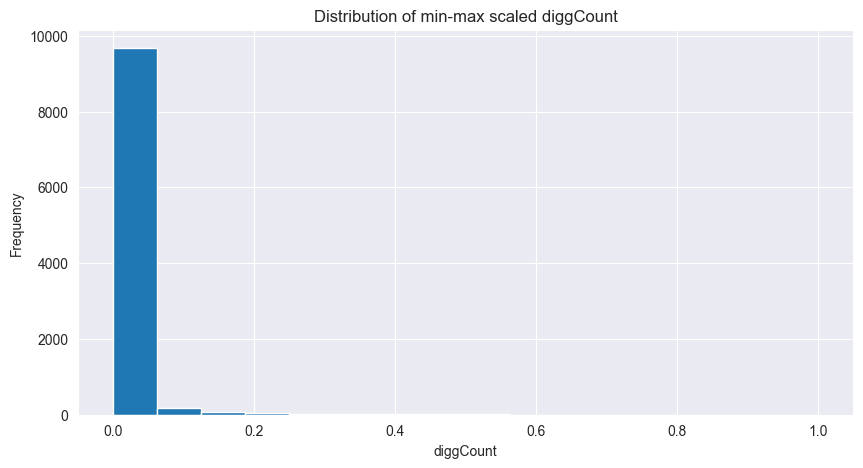

In [ ]:
df_copy['diggCount_minMax'].hist(bins=16, figsize=(10,5))
plt.xlabel('diggCount')
plt.ylabel('Frequency')
plt.title('Distribution of min-max scaled diggCount')
plt.show()

In [ ]:
df_copy['diggCount_minMax'].describe()

count    10043.000000
mean         0.010084
std          0.044672
min          0.000000
25%          0.000505
50%          0.000927
75%          0.001971
max          1.000000
Name: diggCount_minMax, dtype: float64

In [ ]:
df_copy.head()

,diggCount,followerCount,followingCount,heartCount,videoCount,commentSetting,downloadSetting,duetSetting,nickname,openFavorite,...,fake,fakeNum,signatureLength,nicknameLength,nicknameNumSpecialCharacters,nicknameTranslate,uniqueIdNumDigits,uniqueIdLength,diggCount_quantile,diggCount_minMax
0,279,0,564,0,0,0,0,0,Tik Toker,False,...,True,1,0,9,0,Tik Toker,3,13,0.313814,0.000723
1,1198,71,9980,0,0,0,0,0,BEULAH,True,...,True,1,0,6,0,BEULAH,3,21,0.786154,0.003103
2,2968,596,1123,2062,266,0,0,0,Lello27,False,...,False,0,0,7,2,Lello27,0,22,0.854694,0.007687
3,2351,200,818,435,36,0,0,0,clemevitale,False,...,False,0,0,11,0,clemevitale,0,11,0.838426,0.006089
4,40300,1100000,52,10000000,720,0,3,1,Saher Monther,False,...,False,0,16,13,0,Saher Monther,0,12,0.977826,0.104377


#### RobustScaler

In [ ]:
scaler = RobustScaler()
data = df_copy[['diggCount']]
data_scaled = scaler.fit_transform(data)
df_scaled = pd.DataFrame(data_scaled, columns=data.columns)
df_scaled.head()

,diggCount
0,-0.139576
1,1.484099
2,4.611307
3,3.521201
4,70.568905


In [ ]:
df_scaled['diggCount'].describe()

count    10043.000000
mean         6.246327
std         30.473203
min         -0.632509
25%         -0.287986
50%          0.000000
75%          0.712014
max        681.522968
Name: diggCount, dtype: float64

Elimino anche le colonne diggCount_quantile e diggCount_minMax, create per effettuare le prove precedenti.

In [ ]:
df_copy = df_copy.drop(labels='diggCount_quantile', axis=1)
df_copy = df_copy.drop(labels='diggCount_minMax', axis=1)
df_copy.head()

,diggCount,followerCount,followingCount,heartCount,videoCount,commentSetting,downloadSetting,duetSetting,nickname,openFavorite,...,uniqueId,verified,fake,fakeNum,signatureLength,nicknameLength,nicknameNumSpecialCharacters,nicknameTranslate,uniqueIdNumDigits,uniqueIdLength
0,-0.209568,0,564,0,0,0,0,0,Tik Toker,False,...,gyzituvigy542,False,True,1,0,9,0,Tik Toker,3,13
1,-0.156284,71,9980,0,0,0,0,0,BEULAH,True,...,tshphjtowl2401583tbww,False,True,1,0,6,0,BEULAH,3,21
2,-0.053657,596,1123,2062,266,0,0,0,Lello27,False,...,aristanismamojadanuoro,False,False,0,0,7,2,Lello27,0,22
3,-0.089431,200,818,435,36,0,0,0,clemevitale,False,...,clemevitale,False,False,0,0,11,0,clemevitale,0,11
4,2.110897,1100000,52,10000000,720,0,3,1,Saher Monther,False,...,sahermonther,True,False,0,16,13,0,Saher Monther,0,12


### 2.5 Pulizia *followerCount*

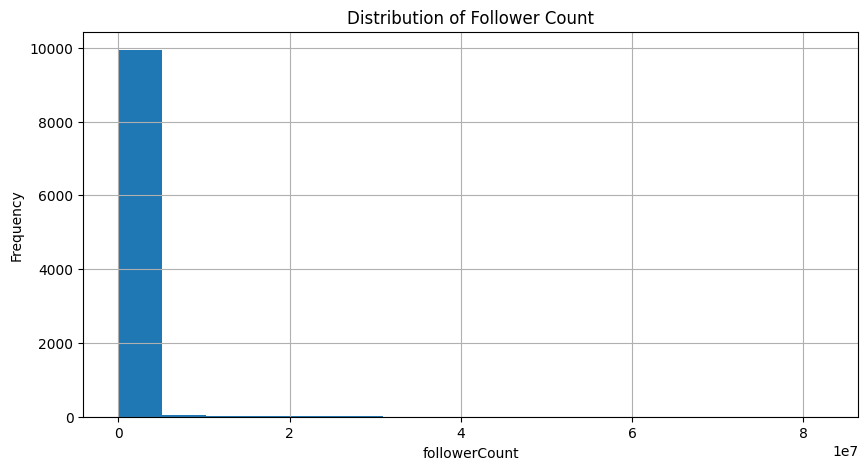

In [ ]:
# Visualizziamo l'istogramma del singolo attributo
df_copy['followerCount'].hist(bins=16, figsize=(10,5))
plt.xlabel('followerCount')
plt.ylabel('Frequency')
plt.title('Distribution of Follower Count')
plt.show()

In [ ]:
df_copy['followerCount'].describe()

count    1.004300e+04
mean     2.218839e+05
std      2.177557e+06
min      0.000000e+00
25%      2.000000e+00
50%      5.400000e+01
75%      5.120000e+02
max      8.230000e+07
Name: followerCount, dtype: float64

Essendo che nello StandardScaler considerato prima, abbiamo ottenuto anche i valori di questo attributo, li assegniamo come fatto anche per *diggCount*.

In [ ]:
# Memorizzo i valori standardizzati in 'followerCount'
df_copy['followerCount'] = df_standardized['followerCount']

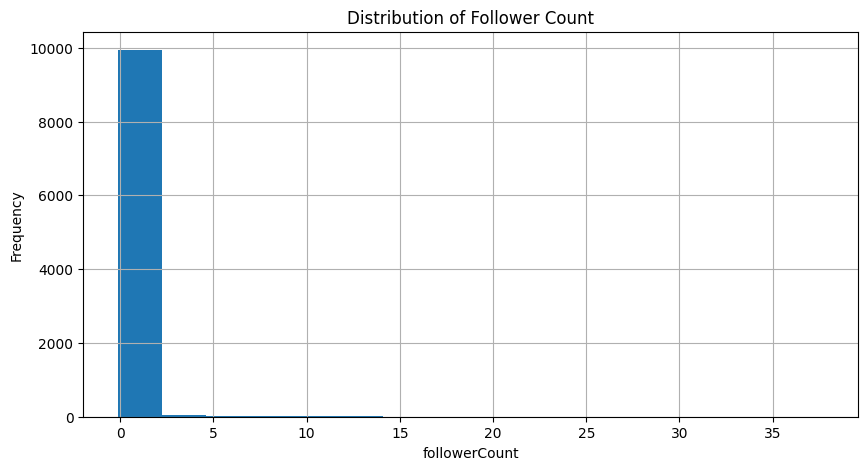

In [ ]:
# Visualizziamo l'istogramma dell'attributo dopo la modifica
df_copy['followerCount'].hist(bins=16, figsize=(10,5))
plt.xlabel('followerCount')
plt.ylabel('Frequency')
plt.title('Distribution of Follower Count')
plt.show()

In [ ]:
df_copy['followerCount'].describe()

count    1.004300e+04
mean     7.428755e-18
std      1.000050e+00
min     -1.019009e-01
25%     -1.019000e-01
50%     -1.018761e-01
75%     -1.016658e-01
max      3.769464e+01
Name: followerCount, dtype: float64

In [ ]:
df_copy.head()

,diggCount,followerCount,followingCount,heartCount,videoCount,commentSetting,downloadSetting,duetSetting,nickname,openFavorite,...,uniqueId,verified,fake,fakeNum,signatureLength,nicknameLength,nicknameNumSpecialCharacters,nicknameTranslate,uniqueIdNumDigits,uniqueIdLength
0,-0.209568,-0.101901,564,0,0,0,0,0,Tik Toker,False,...,gyzituvigy542,False,True,1,0,9,0,Tik Toker,3,13
1,-0.156284,-0.101868,9980,0,0,0,0,0,BEULAH,True,...,tshphjtowl2401583tbww,False,True,1,0,6,0,BEULAH,3,21
2,-0.053657,-0.101627,1123,2062,266,0,0,0,Lello27,False,...,aristanismamojadanuoro,False,False,0,0,7,2,Lello27,0,22
3,-0.089431,-0.101809,818,435,36,0,0,0,clemevitale,False,...,clemevitale,False,False,0,0,11,0,clemevitale,0,11
4,2.110897,0.403278,52,10000000,720,0,3,1,Saher Monther,False,...,sahermonther,True,False,0,16,13,0,Saher Monther,0,12


### 2.6 Pulizia *followingCount*

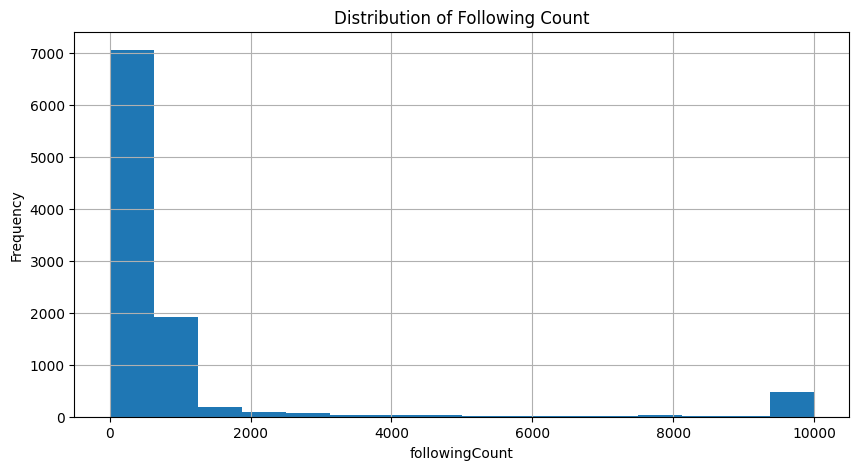

In [ ]:
# Visualizziamo l'istogramma del singolo attributo
df_copy['followingCount'].hist(bins=16, figsize=(10,5))
plt.xlabel('followingCount')
plt.ylabel('Frequency')
plt.title('Distribution of Following Count')
plt.show()

In [ ]:
df_copy['followingCount'].describe()

count    10043.000000
mean      1043.106641
std       2186.721075
min          0.000000
25%        176.000000
50%        533.000000
75%        686.000000
max      10000.000000
Name: followingCount, dtype: float64

Essendo che nello StandardScaler considerato prima, abbiamo ottenuto anche i valori di questo attributo, li assegniamo come fatto anche per diggCount.

In [ ]:
# Memorizzo i valori standardizzati in 'followingCount'
df_copy['followingCount'] = df_standardized['followingCount']

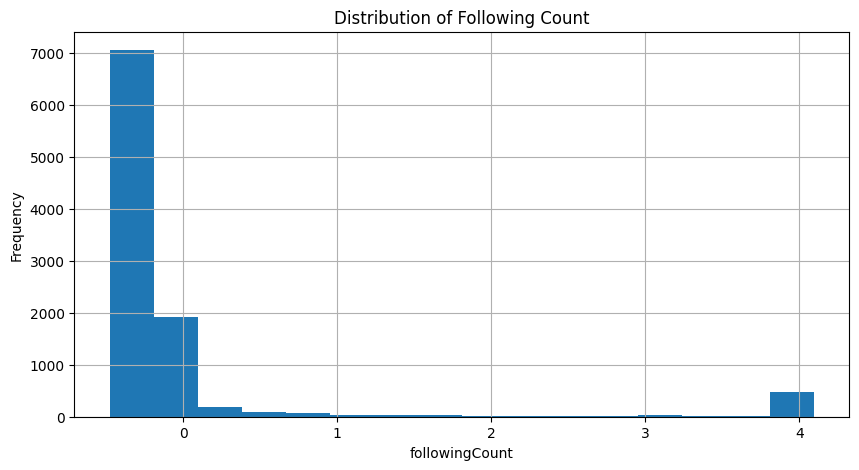

In [ ]:
# Visualizziamo l'istogramma del singolo attributo
df_copy['followingCount'].hist(bins=16, figsize=(10,5))
plt.xlabel('followingCount')
plt.ylabel('Frequency')
plt.title('Distribution of Following Count')
plt.show()

In [ ]:
df_copy['followingCount'].describe()

count    1.004300e+04
mean    -1.874876e-17
std      1.000050e+00
min     -4.770424e-01
25%     -3.965525e-01
50%     -2.332863e-01
75%     -1.633150e-01
max      4.096242e+00
Name: followingCount, dtype: float64

In [ ]:
df_copy.head()

,diggCount,followerCount,followingCount,heartCount,videoCount,commentSetting,downloadSetting,duetSetting,nickname,openFavorite,...,uniqueId,verified,fake,fakeNum,signatureLength,nicknameLength,nicknameNumSpecialCharacters,nicknameTranslate,uniqueIdNumDigits,uniqueIdLength
0,-0.209568,-0.101901,-0.219109,0,0,0,0,0,Tik Toker,False,...,gyzituvigy542,False,True,1,0,9,0,Tik Toker,3,13
1,-0.156284,-0.101868,4.087096,0,0,0,0,0,BEULAH,True,...,tshphjtowl2401583tbww,False,True,1,0,6,0,BEULAH,3,21
2,-0.053657,-0.101627,0.036538,2062,266,0,0,0,Lello27,False,...,aristanismamojadanuoro,False,False,0,0,7,2,Lello27,0,22
3,-0.089431,-0.101809,-0.102948,435,36,0,0,0,clemevitale,False,...,clemevitale,False,False,0,0,11,0,clemevitale,0,11
4,2.110897,0.403278,-0.453261,10000000,720,0,3,1,Saher Monther,False,...,sahermonther,True,False,0,16,13,0,Saher Monther,0,12


### 2.7 Pulizia *heartCount*

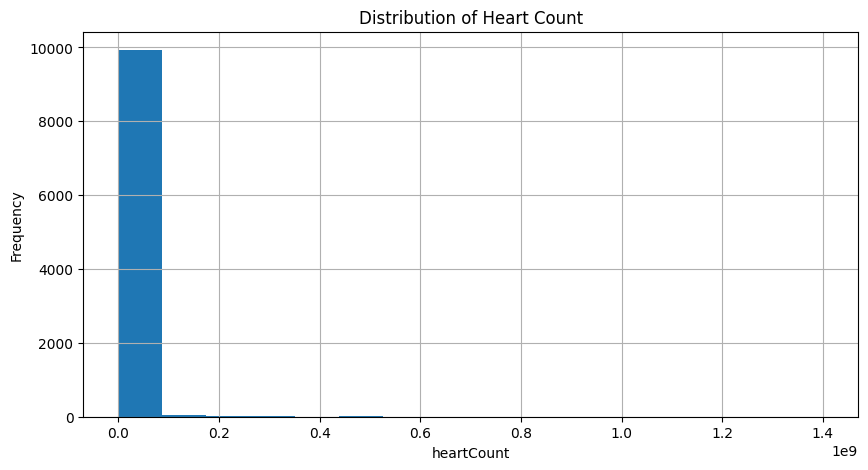

In [ ]:
# Visualizziamo l'istogramma del singolo attributo
df_copy['heartCount'].hist(bins=16, figsize=(10,5))
plt.xlabel('heartCount')
plt.ylabel('Frequency')
plt.title('Distribution of Heart Count')
plt.show()

In [ ]:
df_copy['heartCount'].describe()

count    1.004300e+04
mean     3.978432e+06
std      3.812251e+07
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      9.060000e+02
max      1.400000e+09
Name: heartCount, dtype: float64

Essendo che nello StandardScaler considerato prima, abbiamo ottenuto anche i valori di questo attributo, li assegniamo come fatto anche per diggCount.

In [ ]:
# Memorizzo i valori standardizzati in 'heartCount'
df_copy['heartCount'] = df_standardized['heartCount']

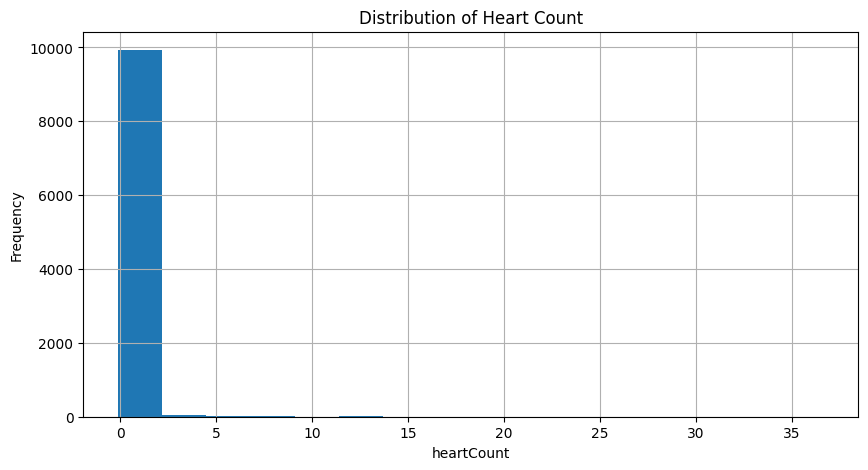

In [ ]:
# Visualizziamo l'istogramma del singolo attributo
df_copy['heartCount'].hist(bins=16, figsize=(10,5))
plt.xlabel('heartCount')
plt.ylabel('Frequency')
plt.title('Distribution of Heart Count')
plt.show()

In [ ]:
df_copy['heartCount'].describe()

count    1.004300e+04
mean    -1.450376e-17
std      1.000050e+00
min     -1.043643e-01
25%     -1.043643e-01
50%     -1.043643e-01
75%     -1.043406e-01
max      3.662117e+01
Name: heartCount, dtype: float64

In [ ]:
df_copy.head()

,diggCount,followerCount,followingCount,heartCount,videoCount,commentSetting,downloadSetting,duetSetting,nickname,openFavorite,...,uniqueId,verified,fake,fakeNum,signatureLength,nicknameLength,nicknameNumSpecialCharacters,nicknameTranslate,uniqueIdNumDigits,uniqueIdLength
0,-0.209568,-0.101901,-0.219109,-0.104364,0,0,0,0,Tik Toker,False,...,gyzituvigy542,False,True,1,0,9,0,Tik Toker,3,13
1,-0.156284,-0.101868,4.087096,-0.104364,0,0,0,0,BEULAH,True,...,tshphjtowl2401583tbww,False,True,1,0,6,0,BEULAH,3,21
2,-0.053657,-0.101627,0.036538,-0.104310,266,0,0,0,Lello27,False,...,aristanismamojadanuoro,False,False,0,0,7,2,Lello27,0,22
3,-0.089431,-0.101809,-0.102948,-0.104353,36,0,0,0,clemevitale,False,...,clemevitale,False,False,0,0,11,0,clemevitale,0,11
4,2.110897,0.403278,-0.453261,0.157961,720,0,3,1,Saher Monther,False,...,sahermonther,True,False,0,16,13,0,Saher Monther,0,12


### 2.8 Pulizia *videoCount*

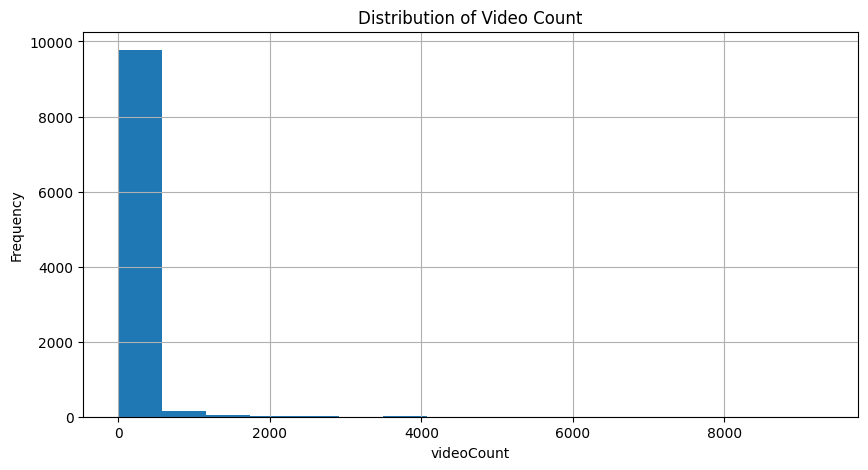

In [ ]:
# Visualizziamo l'istogramma del singolo attributo
df_copy['videoCount'].hist(bins=16, figsize=(10,5))
plt.xlabel('videoCount')
plt.ylabel('Frequency')
plt.title('Distribution of Video Count')
plt.show()

In [ ]:
df_copy['videoCount'].describe()

count    10043.000000
mean        66.211889
std        311.690438
min          0.000000
25%          0.000000
50%          0.000000
75%         17.000000
max       9300.000000
Name: videoCount, dtype: float64

Essendo che nello StandardScaler considerato prima, abbiamo ottenuto anche i valori di questo attributo, li assegniamo come fatto anche per diggCount.

In [ ]:
# Memorizzo i valori standardizzati in 'videoCount'
df_copy['videoCount'] = df_standardized['videoCount']

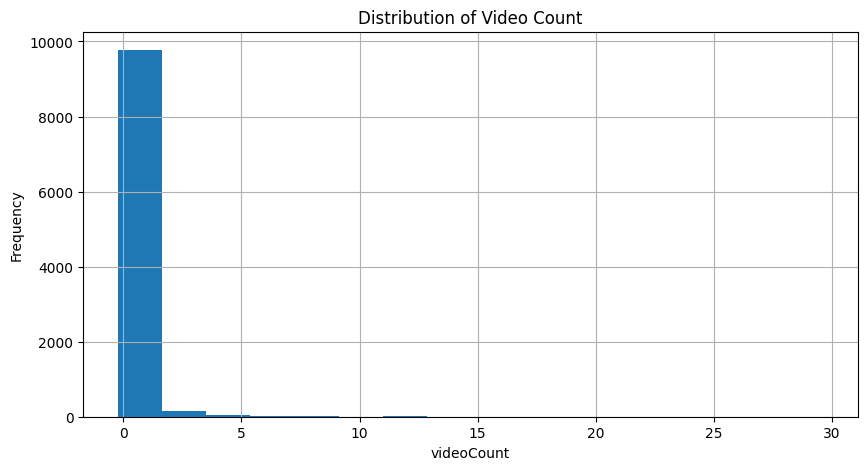

In [ ]:
# Visualizziamo l'istogramma del singolo attributo
df_copy['videoCount'].hist(bins=16, figsize=(10,5))
plt.xlabel('videoCount')
plt.ylabel('Frequency')
plt.title('Distribution of Video Count')
plt.show()

In [ ]:
df_copy['videoCount'].describe()

count    1.004300e+04
mean     1.981001e-17
std      1.000050e+00
min     -2.124389e-01
25%     -2.124389e-01
50%     -2.124389e-01
75%     -1.578949e-01
max      2.962634e+01
Name: videoCount, dtype: float64

In [ ]:
df_copy.head()

,diggCount,followerCount,followingCount,heartCount,videoCount,commentSetting,downloadSetting,duetSetting,nickname,openFavorite,...,uniqueId,verified,fake,fakeNum,signatureLength,nicknameLength,nicknameNumSpecialCharacters,nicknameTranslate,uniqueIdNumDigits,uniqueIdLength
0,-0.209568,-0.101901,-0.219109,-0.104364,-0.212439,0,0,0,Tik Toker,False,...,gyzituvigy542,False,True,1,0,9,0,Tik Toker,3,13
1,-0.156284,-0.101868,4.087096,-0.104364,-0.212439,0,0,0,BEULAH,True,...,tshphjtowl2401583tbww,False,True,1,0,6,0,BEULAH,3,21
2,-0.053657,-0.101627,0.036538,-0.104310,0.641014,0,0,0,Lello27,False,...,aristanismamojadanuoro,False,False,0,0,7,2,Lello27,0,22
3,-0.089431,-0.101809,-0.102948,-0.104353,-0.096934,0,0,0,clemevitale,False,...,clemevitale,False,False,0,0,11,0,clemevitale,0,11
4,2.110897,0.403278,-0.453261,0.157961,2.097660,0,3,1,Saher Monther,False,...,sahermonther,True,False,0,16,13,0,Saher Monther,0,12


### Standardizzazione *signatureLength*, *nicknameLength* e *uniqueIdLength*

In [ ]:
# Memorizzo i valori scalati
df_copy['signatureLength'] = df_standardized['signatureLength']
df_copy['nicknameLength'] = df_standardized['nicknameLength']
df_copy['uniqueIdLength'] = df_standardized['uniqueIdLength']

In [ ]:
df_copy.head()

,diggCount,followerCount,followingCount,heartCount,videoCount,commentSetting,downloadSetting,duetSetting,nickname,openFavorite,...,uniqueId,verified,fake,fakeNum,signatureLength,nicknameLength,nicknameNumSpecialCharacters,nicknameTranslate,uniqueIdNumDigits,uniqueIdLength
0,-0.209568,-0.101901,-0.219109,-0.104364,-0.212439,0,0,0,Tik Toker,False,...,gyzituvigy542,False,True,1,-0.447152,-0.459120,0,Tik Toker,3,-0.223909
1,-0.156284,-0.101868,4.087096,-0.104364,-0.212439,0,0,0,BEULAH,True,...,tshphjtowl2401583tbww,False,True,1,-0.447152,-1.154830,0,BEULAH,3,2.369394
2,-0.053657,-0.101627,0.036538,-0.104310,0.641014,0,0,0,Lello27,False,...,aristanismamojadanuoro,False,False,0,-0.447152,-0.922927,2,Lello27,0,2.693556
3,-0.089431,-0.101809,-0.102948,-0.104353,-0.096934,0,0,0,clemevitale,False,...,clemevitale,False,False,0,-0.447152,0.004687,0,clemevitale,0,-0.872235
4,2.110897,0.403278,-0.453261,0.157961,2.097660,0,3,1,Saher Monther,False,...,sahermonther,True,False,0,0.329291,0.468495,0,Saher Monther,0,-0.548072


### 2.9 Pulizia *openFavorite*

Da booleano, bisogna trasformarlo in intero.

In [ ]:
df_copy['openFavorite'] = np.where(df_copy['openFavorite'] == False, 0, 1)

Verifichiamo che la trasformazione è avvenuta correttamente.

In [ ]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10043 entries, 0 to 10042
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   diggCount                     10043 non-null  float64
 1   followerCount                 10043 non-null  float64
 2   followingCount                10043 non-null  float64
 3   heartCount                    10043 non-null  float64
 4   videoCount                    10043 non-null  float64
 5   commentSetting                10043 non-null  int64  
 6   downloadSetting               10043 non-null  int64  
 7   duetSetting                   10043 non-null  int64  
 8   nickname                      10043 non-null  object 
 9   openFavorite                  10043 non-null  int64  
 10  signature                     10043 non-null  object 
 11  stitchSetting                 10043 non-null  int64  
 12  uniqueId                      10043 non-null  object 
 13  v

In [ ]:
df_copy.head()

,diggCount,followerCount,followingCount,heartCount,videoCount,commentSetting,downloadSetting,duetSetting,nickname,openFavorite,...,uniqueId,verified,fake,fakeNum,signatureLength,nicknameLength,nicknameNumSpecialCharacters,nicknameTranslate,uniqueIdNumDigits,uniqueIdLength
0,-0.209568,-0.101901,-0.219109,-0.104364,-0.212439,0,0,0,Tik Toker,0,...,gyzituvigy542,False,True,1,-0.447152,-0.459120,0,Tik Toker,3,-0.223909
1,-0.156284,-0.101868,4.087096,-0.104364,-0.212439,0,0,0,BEULAH,1,...,tshphjtowl2401583tbww,False,True,1,-0.447152,-1.154830,0,BEULAH,3,2.369394
2,-0.053657,-0.101627,0.036538,-0.104310,0.641014,0,0,0,Lello27,0,...,aristanismamojadanuoro,False,False,0,-0.447152,-0.922927,2,Lello27,0,2.693556
3,-0.089431,-0.101809,-0.102948,-0.104353,-0.096934,0,0,0,clemevitale,0,...,clemevitale,False,False,0,-0.447152,0.004687,0,clemevitale,0,-0.872235
4,2.110897,0.403278,-0.453261,0.157961,2.097660,0,3,1,Saher Monther,0,...,sahermonther,True,False,0,0.329291,0.468495,0,Saher Monther,0,-0.548072


### 2.10 Pulizia *verified*

Da booleano, dobbiamo trasformarlo in intero.

In [ ]:
df_copy['verified'] = np.where(df_copy['verified'] == False, 0, 1)

Verifichiamo che la trasformazione è avvenuta correttamente.

In [ ]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10043 entries, 0 to 10042
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   diggCount                     10043 non-null  float64
 1   followerCount                 10043 non-null  float64
 2   followingCount                10043 non-null  float64
 3   heartCount                    10043 non-null  float64
 4   videoCount                    10043 non-null  float64
 5   commentSetting                10043 non-null  int64  
 6   downloadSetting               10043 non-null  int64  
 7   duetSetting                   10043 non-null  int64  
 8   nickname                      10043 non-null  object 
 9   openFavorite                  10043 non-null  int64  
 10  signature                     10043 non-null  object 
 11  stitchSetting                 10043 non-null  int64  
 12  uniqueId                      10043 non-null  object 
 13  v

In [ ]:
df_copy.head()

,diggCount,followerCount,followingCount,heartCount,videoCount,commentSetting,downloadSetting,duetSetting,nickname,openFavorite,...,uniqueId,verified,fake,fakeNum,signatureLength,nicknameLength,nicknameNumSpecialCharacters,nicknameTranslate,uniqueIdNumDigits,uniqueIdLength
0,-0.209568,-0.101901,-0.219109,-0.104364,-0.212439,0,0,0,Tik Toker,0,...,gyzituvigy542,0,True,1,-0.447152,-0.459120,0,Tik Toker,3,-0.223909
1,-0.156284,-0.101868,4.087096,-0.104364,-0.212439,0,0,0,BEULAH,1,...,tshphjtowl2401583tbww,0,True,1,-0.447152,-1.154830,0,BEULAH,3,2.369394
2,-0.053657,-0.101627,0.036538,-0.104310,0.641014,0,0,0,Lello27,0,...,aristanismamojadanuoro,0,False,0,-0.447152,-0.922927,2,Lello27,0,2.693556
3,-0.089431,-0.101809,-0.102948,-0.104353,-0.096934,0,0,0,clemevitale,0,...,clemevitale,0,False,0,-0.447152,0.004687,0,clemevitale,0,-0.872235
4,2.110897,0.403278,-0.453261,0.157961,2.097660,0,3,1,Saher Monther,0,...,sahermonther,1,False,0,0.329291,0.468495,0,Saher Monther,0,-0.548072


### 2.11 Pulizia *fake*

Essendo che una colonna *fakeNum* già c'è, provvediamo a lasciare quella e rinominarla.

In [ ]:
# Elimino la colonna 'fake'
df_copy.drop(columns=['fake'], inplace=True)

# Rinomino la colonna 'fakeNum' con 'fake'
df_copy.rename(columns={'fakeNum': 'fake'}, inplace=True)

In [ ]:
df_copy.head()

,diggCount,followerCount,followingCount,heartCount,videoCount,commentSetting,downloadSetting,duetSetting,nickname,openFavorite,...,stitchSetting,uniqueId,verified,fake,signatureLength,nicknameLength,nicknameNumSpecialCharacters,nicknameTranslate,uniqueIdNumDigits,uniqueIdLength
0,-0.209568,-0.101901,-0.219109,-0.104364,-0.212439,0,0,0,Tik Toker,0,...,0,gyzituvigy542,0,1,-0.447152,-0.459120,0,Tik Toker,3,-0.223909
1,-0.156284,-0.101868,4.087096,-0.104364,-0.212439,0,0,0,BEULAH,1,...,0,tshphjtowl2401583tbww,0,1,-0.447152,-1.154830,0,BEULAH,3,2.369394
2,-0.053657,-0.101627,0.036538,-0.104310,0.641014,0,0,0,Lello27,0,...,0,aristanismamojadanuoro,0,0,-0.447152,-0.922927,2,Lello27,0,2.693556
3,-0.089431,-0.101809,-0.102948,-0.104353,-0.096934,0,0,0,clemevitale,0,...,0,clemevitale,0,0,-0.447152,0.004687,0,clemevitale,0,-0.872235
4,2.110897,0.403278,-0.453261,0.157961,2.097660,0,3,1,Saher Monther,0,...,0,sahermonther,1,0,0.329291,0.468495,0,Saher Monther,0,-0.548072


## 3. Rimozione feature

> Si eliminano le feature che ormai non servono più, cioè *nickname*, *signature*, *uniqueId* e *nicknameTranslate*.

In [ ]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10043 entries, 0 to 10042
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   diggCount                     10043 non-null  float64
 1   followerCount                 10043 non-null  float64
 2   followingCount                10043 non-null  float64
 3   heartCount                    10043 non-null  float64
 4   videoCount                    10043 non-null  float64
 5   commentSetting                10043 non-null  int64  
 6   downloadSetting               10043 non-null  int64  
 7   duetSetting                   10043 non-null  int64  
 8   nickname                      10043 non-null  object 
 9   openFavorite                  10043 non-null  int64  
 10  signature                     10043 non-null  object 
 11  stitchSetting                 10043 non-null  int64  
 12  uniqueId                      10043 non-null  object 
 13  v

In [ ]:
df_copy = df_copy.drop(labels='signature', axis=1)
df_copy = df_copy.drop(labels='uniqueId', axis=1)
df_copy = df_copy.drop(labels='nickname', axis=1)
df_copy = df_copy.drop(labels='nicknameTranslate', axis=1)

In [ ]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10043 entries, 0 to 10042
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   diggCount                     10043 non-null  float64
 1   followerCount                 10043 non-null  float64
 2   followingCount                10043 non-null  float64
 3   heartCount                    10043 non-null  float64
 4   videoCount                    10043 non-null  float64
 5   commentSetting                10043 non-null  int64  
 6   downloadSetting               10043 non-null  int64  
 7   duetSetting                   10043 non-null  int64  
 8   openFavorite                  10043 non-null  int64  
 9   stitchSetting                 10043 non-null  int64  
 10  verified                      10043 non-null  int64  
 11  fake                          10043 non-null  int64  
 12  signatureLength               10043 non-null  float64
 13  n

> Si procede a rilevare la matrice delle correlazioni dopo la pulizia, e verificare se l'attributo *commentSetting* è ancora poco correlato.

In [ ]:
corr_matrix = df_copy.corr()
corr_matrix['fake'].sort_values(ascending=False)

fake                            1.000000
followingCount                  0.250169
uniqueIdNumDigits               0.196982
uniqueIdLength                  0.177612
openFavorite                    0.159900
commentSetting                 -0.067205
followerCount                  -0.102048
heartCount                     -0.104520
duetSetting                    -0.186717
stitchSetting                  -0.190654
diggCount                      -0.204800
videoCount                     -0.210097
downloadSetting                -0.227304
verified                       -0.229723
nicknameLength                 -0.335022
nicknameNumSpecialCharacters   -0.369125
signatureLength                -0.446091
Name: fake, dtype: float64

L'assenza di correlazione si è verificata anche dopo la pulizia, per cui si procede a rimuovere l'attributo.

In [ ]:
df_copy = df_copy.drop(labels='commentSetting', axis=1)
df_copy.head()

,diggCount,followerCount,followingCount,heartCount,videoCount,downloadSetting,duetSetting,openFavorite,stitchSetting,verified,fake,signatureLength,nicknameLength,nicknameNumSpecialCharacters,uniqueIdNumDigits,uniqueIdLength
0,-0.209568,-0.101901,-0.219109,-0.104364,-0.212439,0,0,0,0,0,1,-0.447152,-0.459120,0,3,-0.223909
1,-0.156284,-0.101868,4.087096,-0.104364,-0.212439,0,0,1,0,0,1,-0.447152,-1.154830,0,3,2.369394
2,-0.053657,-0.101627,0.036538,-0.104310,0.641014,0,0,0,0,0,0,-0.447152,-0.922927,2,0,2.693556
3,-0.089431,-0.101809,-0.102948,-0.104353,-0.096934,0,0,0,0,0,0,-0.447152,0.004687,0,0,-0.872235
4,2.110897,0.403278,-0.453261,0.157961,2.097660,3,1,0,0,1,0,0.329291,0.468495,0,0,-0.548072


In [ ]:
# Sposto la colonna 'fake' in modo che sia l'ultima colonna
col_fake = df_copy.pop('fake')

# Aggiungo la colonna 'fake' come ultima colonna
df_copy['fake'] = col_fake

In [ ]:
df_copy.head()

,diggCount,followerCount,followingCount,heartCount,videoCount,downloadSetting,duetSetting,openFavorite,stitchSetting,verified,signatureLength,nicknameLength,nicknameNumSpecialCharacters,uniqueIdNumDigits,uniqueIdLength,fake
0,-0.209568,-0.101901,-0.219109,-0.104364,-0.212439,0,0,0,0,0,-0.447152,-0.459120,0,3,-0.223909,1
1,-0.156284,-0.101868,4.087096,-0.104364,-0.212439,0,0,1,0,0,-0.447152,-1.154830,0,3,2.369394,1
2,-0.053657,-0.101627,0.036538,-0.104310,0.641014,0,0,0,0,0,-0.447152,-0.922927,2,0,2.693556,0
3,-0.089431,-0.101809,-0.102948,-0.104353,-0.096934,0,0,0,0,0,-0.447152,0.004687,0,0,-0.872235,0
4,2.110897,0.403278,-0.453261,0.157961,2.097660,3,1,0,0,1,0.329291,0.468495,0,0,-0.548072,0


## 4. Salvataggio dataset pulito

In [ ]:
# Salvo il file in CSV (drive)
df_copy.to_csv('/content/drive/MyDrive/Progetto_FDSML/tiktok_accounts_cleaned.csv', index=False)

In [ ]:
# Salvo il file in CSV (locale)
df_copy.to_csv('../datasets/tiktok_accounts_cleaned.csv', index=False)